In [1]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm

import gc
import datetime

from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

In [2]:
train_all = pd.read_csv("../input/train_2.csv")

In [3]:
def process_train(train, copy=True):
    if copy:
        train = train[['Page']].copy()
    data = [page.split('_') for page in tqdm(train.Page)]
    access_agent = ['_'.join(page[-2:]) for page in data]
    site = [page[-3] for page in data]
    page = ['_'.join(page[:-3]) for page in data]

    train['PageTitle'] = page
    train['Site'] = site
    train['AccessAgent'] = access_agent
    return train

def process_date(test_all, create_date=True):
    if create_date:
        test_all['Date'] = test_all.Page.apply(lambda s: s[-10:])
        test_all['Page'] = test_all.Page.apply(lambda a: a[:-11])
    test_all.Date = pd.to_datetime(test_all.Date)
    test_all['WeekDay'] = test_all.Date.dt.dayofweek
    test_all['YearDay'] = test_all.Date.dt.dayofyear
    test_all.YearDay -= test_all.YearDay.min()

In [4]:
train_key = process_train(train_all)
train_key.head()

100%|██████████| 145063/145063 [00:00<00:00, 338219.52it/s]


,Page,PageTitle,Site,AccessAgent
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh.wikipedia.org,all-access_spider
1,2PM_zh.wikipedia.org_all-access_spider,2PM,zh.wikipedia.org,all-access_spider
2,3C_zh.wikipedia.org_all-access_spider,3C,zh.wikipedia.org,all-access_spider
3,4minute_zh.wikipedia.org_all-access_spider,4minute,zh.wikipedia.org,all-access_spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You,zh.wikipedia.org,all-access_spider


In [5]:
max_size = 184 # number of days in 2015

all_page = train_all.Page.copy()

In [6]:
def get_date_index(date, train_all=train_all):
    for idx, c in enumerate(train_all.columns):
        if date == c:
            break
    if idx == len(train_all.columns):
        return None
    return idx

In [7]:
train_end = get_date_index('2016-09-10') + 1
test_start = get_date_index('2016-09-13')

In [8]:
train = train_all.iloc[ : , (train_end - max_size) : train_end].copy().astype('float32')
test = train_all.iloc[:, test_start : (63 + test_start)].copy().astype('float32')

train_all = train_all.iloc[:,-(max_size):].astype('float32')

train = train.iloc[:,::-1].copy()
train_all = train_all.iloc[:,::-1].copy()

In [9]:
train.head()

,2016-09-10,2016-09-09,2016-09-08,2016-09-07,2016-09-06,2016-09-05,2016-09-04,2016-09-03,2016-09-02,2016-09-01,2016-08-31,2016-08-30,2016-08-29,2016-08-28,2016-08-27,2016-08-26,2016-08-25,2016-08-24,2016-08-23,2016-08-22,2016-08-21,2016-08-20,2016-08-19,2016-08-18,2016-08-17,2016-08-16,2016-08-15,2016-08-14,2016-08-13,2016-08-12,2016-08-11,2016-08-10,2016-08-09,2016-08-08,2016-08-07,2016-08-06,2016-08-05,2016-08-04,2016-08-03,2016-08-02,2016-08-01,2016-07-31,2016-07-30,2016-07-29,2016-07-28,2016-07-27,2016-07-26,2016-07-25,2016-07-24,2016-07-23,...,2016-04-29,2016-04-28,2016-04-27,2016-04-26,2016-04-25,2016-04-24,2016-04-23,2016-04-22,2016-04-21,2016-04-20,2016-04-19,2016-04-18,2016-04-17,2016-04-16,2016-04-15,2016-04-14,2016-04-13,2016-04-12,2016-04-11,2016-04-10,2016-04-09,2016-04-08,2016-04-07,2016-04-06,2016-04-05,2016-04-04,2016-04-03,2016-04-02,2016-04-01,2016-03-31,2016-03-30,2016-03-29,2016-03-28,2016-03-27,2016-03-26,2016-03-25,2016-03-24,2016-03-23,2016-03-22,2016-03-21,2016-03-20,2016-03-19,2016-03-18,2016-03-17,2016-03-16,2016-03-15,2016-03-14,2016-03-13,2016-03-12,2016-03-11
0,16.0,55.0,18.0,19.0,18.0,23.0,19.0,25.0,20.0,21.0,25.0,8.0,26.0,18.0,15.0,40.0,14.0,20.0,33.0,20.0,30.0,13.0,37.0,42.0,49.0,12.0,14.0,24.0,17.0,55.0,30.0,23.0,41.0,26.0,19.0,10.0,49.0,20.0,17.0,57.0,19.0,19.0,12.0,29.0,26.0,31.0,17.0,18.0,13.0,12.0,...,15.0,15.0,19.0,40.0,25.0,17.0,31.0,6.0,44.0,22.0,18.0,23.0,16.0,23.0,17.0,17.0,79.0,57.0,21.0,71.0,126.0,38.0,102.0,189.0,490.0,9.0,13.0,14.0,12.0,17.0,18.0,11.0,59.0,20.0,11.0,15.0,8.0,11.0,12.0,11.0,13.0,18.0,6.0,17.0,14.0,10.0,9.0,17.0,9.0,8.0
1,13.0,13.0,35.0,43.0,44.0,19.0,78.0,66.0,17.0,31.0,31.0,144.0,22.0,25.0,12.0,15.0,23.0,14.0,10.0,29.0,20.0,13.0,30.0,34.0,9.0,12.0,63.0,77.0,12.0,60.0,17.0,19.0,39.0,15.0,54.0,16.0,30.0,29.0,19.0,39.0,24.0,25.0,19.0,49.0,35.0,17.0,18.0,18.0,19.0,22.0,...,22.0,64.0,9.0,16.0,35.0,41.0,17.0,17.0,39.0,61.0,14.0,10.0,42.0,11.0,15.0,16.0,37.0,20.0,14.0,19.0,15.0,13.0,16.0,17.0,20.0,16.0,18.0,18.0,25.0,12.0,23.0,36.0,28.0,15.0,14.0,15.0,14.0,17.0,12.0,17.0,15.0,17.0,46.0,18.0,22.0,16.0,36.0,11.0,15.0,7.0
2,19.0,5.0,10.0,11.0,6.0,7.0,2.0,5.0,7.0,5.0,2.0,4.0,5.0,3.0,2.0,3.0,5.0,2.0,4.0,4.0,2.0,2.0,7.0,2.0,1.0,4.0,2.0,6.0,5.0,3.0,13.0,7.0,6.0,5.0,1.0,2.0,7.0,9.0,3.0,3.0,5.0,4.0,5.0,7.0,3.0,2.0,2.0,6.0,11.0,2.0,...,6.0,7.0,3.0,7.0,2.0,5.0,6.0,4.0,8.0,7.0,9.0,10.0,7.0,6.0,4.0,3.0,7.0,5.0,8.0,8.0,13.0,6.0,16.0,31.0,48.0,83.0,155.0,155.0,4.0,2.0,6.0,4.0,7.0,6.0,1.0,5.0,9.0,10.0,1.0,1.0,7.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,3.0,3.0
3,9.0,11.0,13.0,14.0,7.0,11.0,16.0,9.0,14.0,14.0,9.0,7.0,19.0,15.0,27.0,13.0,9.0,18.0,7.0,5.0,22.0,8.0,11.0,11.0,13.0,7.0,15.0,17.0,17.0,55.0,15.0,23.0,16.0,21.0,32.0,17.0,11.0,10.0,10.0,16.0,13.0,13.0,9.0,14.0,19.0,8.0,16.0,13.0,8.0,43.0,...,10.0,9.0,19.0,11.0,21.0,23.0,14.0,14.0,12.0,15.0,15.0,15.0,8.0,114.0,74.0,17.0,23.0,10.0,15.0,14.0,26.0,9.0,16.0,11.0,39.0,27.0,23.0,18.0,18.0,25.0,25.0,13.0,12.0,12.0,16.0,10.0,10.0,10.0,13.0,11.0,17.0,28.0,9.0,11.0,8.0,12.0,10.0,15.0,9.0,9.0
4,5.0,5.0,5.0,5.0,1.0,3.0,4.0,39.0,3.0,4.0,2.0,3.0,2.0,5.0,3.0,1.0,3.0,3.0,4.0,2.0,4.0,13.0,0.0,2.0,3.0,4.0,3.0,2.0,3.0,1.0,2.0,6.0,6.0,2.0,1.0,1.0,5.0,2.0,8.0,5.0,2.0,7.0,5.0,2.0,10.0,3.0,5.0,10.0,2.0,4.0,...,55.0,3.0,0.0,5.0,0.0,2.0,9.0,10.0,1.0,4.0,9.0,159.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Sept 10, 2016 is a Saturday, dayofweek = 5
train_weekday = np.array([(5-w) % 7 for w in range(train.shape[1])])
train_weekday[:10]

array([5, 4, 3, 2, 1, 0, 6, 5, 4, 3])

In [11]:
# Sept 10, 2017 is a Sunday, dayofweek = 6
train_all_weekday = np.array([(6-w) % 7 for w in range(train_all.shape[1])])
train_all_weekday[:10]

array([6, 5, 4, 3, 2, 1, 0, 6, 5, 4])

In [12]:
test_all = pd.read_csv("../input/key_2.csv")
process_date(test_all)
test_all = process_train(test_all, copy=False)
test_all.head()

100%|██████████| 8993906/8993906 [00:27<00:00, 323426.63it/s]


,Page,Id,Date,WeekDay,YearDay,PageTitle,Site,AccessAgent
0,007_スペクター_ja.wikipedia.org_all-access_all-agents,0b293039387a,2017-09-13,2,0,007_スペクター,ja.wikipedia.org,all-access_all-agents
1,007_スペクター_ja.wikipedia.org_all-access_all-agents,7114389dd824,2017-09-14,3,1,007_スペクター,ja.wikipedia.org,all-access_all-agents
2,007_スペクター_ja.wikipedia.org_all-access_all-agents,057b02ff1f09,2017-09-15,4,2,007_スペクター,ja.wikipedia.org,all-access_all-agents
3,007_スペクター_ja.wikipedia.org_all-access_all-agents,bd2aca21caa3,2017-09-16,5,3,007_スペクター,ja.wikipedia.org,all-access_all-agents
4,007_スペクター_ja.wikipedia.org_all-access_all-agents,c0effb42cdd5,2017-09-17,6,4,007_スペクター,ja.wikipedia.org,all-access_all-agents


In [13]:
test['Page'] = all_page
test = pd.melt(test, id_vars=['Page'], var_name='Date', value_name='Visits_true')
test = process_train(test, copy=False)
process_date(test, create_date=False)
test.head()

100%|██████████| 9138969/9138969 [00:24<00:00, 368895.04it/s]


,Page,Date,Visits_true,PageTitle,Site,AccessAgent,WeekDay,YearDay
0,2NE1_zh.wikipedia.org_all-access_spider,2016-09-13,11.0,2NE1,zh.wikipedia.org,all-access_spider,1,0
1,2PM_zh.wikipedia.org_all-access_spider,2016-09-13,37.0,2PM,zh.wikipedia.org,all-access_spider,1,0
2,3C_zh.wikipedia.org_all-access_spider,2016-09-13,4.0,3C,zh.wikipedia.org,all-access_spider,1,0
3,4minute_zh.wikipedia.org_all-access_spider,2016-09-13,11.0,4minute,zh.wikipedia.org,all-access_spider,1,0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,2016-09-13,13.0,52_Hz_I_Love_You,zh.wikipedia.org,all-access_spider,1,0


In [14]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [15]:
def smape_check(y_true, y_pred):
    y_pred = y_pred[y_true != np.NaN]
    y_true = y_true[y_true != np.NaN]
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [16]:
train_keras_kf_3 = pd.read_csv('../submissions/keras_kf_12_stage2_sept_10_train.csv')

In [17]:
train_keras_kf_3.head()

,Page,Date,Visits
0,!vote_en.wikipedia.org_all-access_all-agents,2016-09-13,3.0
1,!vote_en.wikipedia.org_all-access_spider,2016-09-13,1.0
2,!vote_en.wikipedia.org_desktop_all-agents,2016-09-13,3.0
3,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",2016-09-13,0.0
4,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",2016-09-13,0.0


In [18]:
train_keras_kf_3.shape

(9138969, 3)

In [19]:
test.shape

(9138969, 8)

In [20]:
np.sum(train_keras_kf_3.Page.isnull())

0

In [21]:
train_keras_kf_3.Date = pd.to_datetime(train_keras_kf_3.Date)
train_keras_kf_3 = test[['Page', 'Date']].merge(train_keras_kf_3, how='left', on=['Page', 'Date'])

In [22]:
np.sum(train_keras_kf_3.Page.isnull())

0

In [23]:
train_keras_kf_3.shape

(9138969, 3)

In [24]:
smape_check(test.Visits_true.values, train_keras_kf_3.Visits)

0.415085493107434

In [25]:
test['Visits_keras_kf_3'] = train_keras_kf_3.Visits.values

In [26]:
test['Visits_keras_kf_3'].isnull().sum()

0

In [27]:
test[test['Visits_keras_kf_3'].isnull()]

,Page,Date,Visits_true,PageTitle,Site,AccessAgent,WeekDay,YearDay,Visits_keras_kf_3


In [28]:
test.shape

(9138969, 9)

In [29]:
smape_check(test.Visits_true.values, test.Visits_keras_kf_3)

0.415085493107434

In [30]:
train_keras_kf_3.shape

(9138969, 3)

In [31]:
test.head()

,Page,Date,Visits_true,PageTitle,Site,AccessAgent,WeekDay,YearDay,Visits_keras_kf_3
0,2NE1_zh.wikipedia.org_all-access_spider,2016-09-13,11.0,2NE1,zh.wikipedia.org,all-access_spider,1,0,17.0
1,2PM_zh.wikipedia.org_all-access_spider,2016-09-13,37.0,2PM,zh.wikipedia.org,all-access_spider,1,0,20.0
2,3C_zh.wikipedia.org_all-access_spider,2016-09-13,4.0,3C,zh.wikipedia.org,all-access_spider,1,0,4.0
3,4minute_zh.wikipedia.org_all-access_spider,2016-09-13,11.0,4minute,zh.wikipedia.org,all-access_spider,1,0,12.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,2016-09-13,13.0,52_Hz_I_Love_You,zh.wikipedia.org,all-access_spider,1,0,3.0


In [32]:
test.shape

(9138969, 9)

In [33]:
test_keras_kf_3 = pd.read_csv('../submissions/keras_kf_12_stage2_sept_10_test.csv')

In [34]:
test_keras_kf_3.head()

,Id,Visits
0,0b293039387a,455.0
1,7114389dd824,456.0
2,057b02ff1f09,466.0
3,bd2aca21caa3,518.0
4,c0effb42cdd5,543.0


In [35]:
test_keras_kf_3 = test_all[['Id']].merge(test_keras_kf_3, how='left', on=['Id'])
test_all['Visits_keras_kf_3'] = test_keras_kf_3.Visits

In [36]:
test_all.head()

,Page,Id,Date,WeekDay,YearDay,PageTitle,Site,AccessAgent,Visits_keras_kf_3
0,007_スペクター_ja.wikipedia.org_all-access_all-agents,0b293039387a,2017-09-13,2,0,007_スペクター,ja.wikipedia.org,all-access_all-agents,455.0
1,007_スペクター_ja.wikipedia.org_all-access_all-agents,7114389dd824,2017-09-14,3,1,007_スペクター,ja.wikipedia.org,all-access_all-agents,456.0
2,007_スペクター_ja.wikipedia.org_all-access_all-agents,057b02ff1f09,2017-09-15,4,2,007_スペクター,ja.wikipedia.org,all-access_all-agents,466.0
3,007_スペクター_ja.wikipedia.org_all-access_all-agents,bd2aca21caa3,2017-09-16,5,3,007_スペクター,ja.wikipedia.org,all-access_all-agents,518.0
4,007_スペクター_ja.wikipedia.org_all-access_all-agents,c0effb42cdd5,2017-09-17,6,4,007_スペクター,ja.wikipedia.org,all-access_all-agents,543.0


In [37]:
for c in test.columns:
    print(c, test[c].isnull().sum())

for c in test_all.columns:
    print(c, test_all[c].isnull().sum())

Page 0
Date 0
Visits_true 316446
PageTitle 0
Site 0
AccessAgent 0
WeekDay 0
YearDay 0
Visits_keras_kf_3 0
Page 0
Id 0
Date 0
WeekDay 0
YearDay 0
PageTitle 0
Site 0
AccessAgent 0
Visits_keras_kf_3 0


In [38]:
test = test[test.Visits_true.isnull() != True].reset_index(drop=True)
test.shape


(8822523, 9)

In [39]:
pred_10_train = pd.read_csv('../submissions/pred_10_stage2_sept_10_train.csv')
pred_10_train.head()

,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2016-09-13,17.363
1,2PM_zh.wikipedia.org_all-access_spider,2016-09-13,30.356
2,3C_zh.wikipedia.org_all-access_spider,2016-09-13,7.523
3,4minute_zh.wikipedia.org_all-access_spider,2016-09-13,12.516
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,2016-09-13,4.544


In [40]:
pred_10_test = pd.read_csv('../submissions/pred_10_stage2_sept_10_test.csv')
pred_10_test.head()

,Id,Visits
0,0b293039387a,485.032
1,7114389dd824,485.032
2,057b02ff1f09,485.032
3,bd2aca21caa3,431.920
4,c0effb42cdd5,431.920


In [41]:
test['Visits_pred_10'] = pred_10_train.Visits.astype('float32')
pred_10_test = test_all[['Id']].merge(pred_10_test, how='left', on=['Id'])

test_all['Visits_pred_10'] = pred_10_test.Visits.astype('float32')

In [42]:
test_all.head()

,Page,Id,Date,WeekDay,YearDay,PageTitle,Site,AccessAgent,Visits_keras_kf_3,Visits_pred_10
0,007_スペクター_ja.wikipedia.org_all-access_all-agents,0b293039387a,2017-09-13,2,0,007_スペクター,ja.wikipedia.org,all-access_all-agents,455.0,485.032013
1,007_スペクター_ja.wikipedia.org_all-access_all-agents,7114389dd824,2017-09-14,3,1,007_スペクター,ja.wikipedia.org,all-access_all-agents,456.0,485.032013
2,007_スペクター_ja.wikipedia.org_all-access_all-agents,057b02ff1f09,2017-09-15,4,2,007_スペクター,ja.wikipedia.org,all-access_all-agents,466.0,485.032013
3,007_スペクター_ja.wikipedia.org_all-access_all-agents,bd2aca21caa3,2017-09-16,5,3,007_スペクター,ja.wikipedia.org,all-access_all-agents,518.0,431.920013
4,007_スペクター_ja.wikipedia.org_all-access_all-agents,c0effb42cdd5,2017-09-17,6,4,007_スペクター,ja.wikipedia.org,all-access_all-agents,543.0,431.920013


In [43]:
del pred_10_train
del pred_10_test
gc.collect()

520

In [44]:
for c in test.columns:
    print(c, test[c].isnull().sum())

for c in test_all.columns:
    print(c, test_all[c].isnull().sum())

Page 0
Date 0
Visits_true 0
PageTitle 0
Site 0
AccessAgent 0
WeekDay 0
YearDay 0
Visits_keras_kf_3 0
Visits_pred_10 0
Page 0
Id 0
Date 0
WeekDay 0
YearDay 0
PageTitle 0
Site 0
AccessAgent 0
Visits_keras_kf_3 0
Visits_pred_10 0


In [45]:
smape(test.Visits_true, test.Visits_pred_10)

0.4530934831490426

In [46]:
smape(test.Visits_true, test.Visits_keras_kf_3)

0.415085493107434

In [47]:
test = test.sort_values(by=['Page', 'Date']).reset_index(drop=True)
test.head()

,Page,Date,Visits_true,PageTitle,Site,AccessAgent,WeekDay,YearDay,Visits_keras_kf_3,Visits_pred_10
0,!vote_en.wikipedia.org_all-access_all-agents,2016-09-13,3.0,!vote,en.wikipedia.org,all-access_all-agents,1,0,3.0,4.232
1,!vote_en.wikipedia.org_all-access_all-agents,2016-09-14,2.0,!vote,en.wikipedia.org,all-access_all-agents,2,1,3.0,4.232
2,!vote_en.wikipedia.org_all-access_all-agents,2016-09-15,5.0,!vote,en.wikipedia.org,all-access_all-agents,3,2,3.0,4.012
3,!vote_en.wikipedia.org_all-access_all-agents,2016-09-16,1.0,!vote,en.wikipedia.org,all-access_all-agents,4,3,3.0,4.012
4,!vote_en.wikipedia.org_all-access_all-agents,2016-09-17,3.0,!vote,en.wikipedia.org,all-access_all-agents,5,4,4.0,2.748


In [48]:
def smape_mask(y_true, y_pred, threshold):
    denominator = (np.abs(y_true) + np.abs(y_pred)) 
    diff = np.abs(y_true - y_pred) 
    diff[denominator == 0] = 0.0
    
    return diff <= (threshold / 2.0) * denominator

In [49]:
train_page = all_page.to_frame()

In [50]:
sites = train_key.Site.unique()
sites

array(['zh.wikipedia.org', 'fr.wikipedia.org', 'en.wikipedia.org',
       'commons.wikimedia.org', 'ru.wikipedia.org', 'www.mediawiki.org',
       'de.wikipedia.org', 'ja.wikipedia.org', 'es.wikipedia.org'], dtype=object)

In [51]:
access = train_key.AccessAgent.unique()
access

array(['all-access_spider', 'desktop_all-agents', 'mobile-web_all-agents',
       'all-access_all-agents'], dtype=object)

In [54]:
# 1 week
test['Month'] = (test.YearDay) // 7
test_all['Month'] = (test_all.YearDay) // 7
months = test_all.Month.unique()
months


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [55]:
#log transform
# substract median baseline, not mean baseline

def add_median(test, train, train_key, periods, max_periods, first_train_weekday):
    train =  np.log1p(train.iloc[:,:7*max_periods])
    train_weekday = np.array([(first_train_weekday-w) % 7 for w in range(train.shape[1])])
    train_week_idx = [i for i,w in enumerate(train_weekday) if w < 4]
    train_week = train.iloc[:,train_week_idx]
    train_weekend_idx = [i for i,w in enumerate(train_weekday) if w >= 4]
    train_weekend = train.iloc[:,train_weekend_idx]
    
    all_median = train.median(axis=1, skipna=True)
    df = train_key[['Page']].copy()
    df['AllVisits'] = all_median.fillna(0)
    test = test.merge(df, how='left', on='Page')
    
    test_week = (test.WeekDay < 4)
    test_weekend = ~test_week
    test['WeekEnd'] = 1 * test_weekend
    
    for (w1, w2) in tqdm(periods):
        
        df = train_key[['Page']].copy()
        c = 'median_%d_%d' % (w1, w2)
        c1 = c + '_ratio'
        cm = 'mean_%d_%d' % (w1, w2)
        cm1 = cm + '_ratio'
        df[c] = train.iloc[:,7*w1:7*w2].median(axis=1, skipna=True) 
        df[c1] = df[c] - all_median
        df[cm] = train.iloc[:,7*w1:7*w2].mean(axis=1, skipna=True) 
        df[cm1] = df[cm] - all_median
        test = test.merge(df, how='left', on='Page')
        test[c] = test[c].astype('float32')
        test[c1] = test[c1].astype('float32')
        test[cm] = test[cm].astype('float32')
        test[cm1] = test[cm1].astype('float32')
        
        c = 'median_day_%d_%d' % (w1, w2)
        c1 = c + '_ratio' 
        cm = 'mean_%d_%d' % (w1, w2)
        cm1 = cm + '_ratio'
        test_page = test[['Page']].copy()
        
        df = train_key[['Page']].copy()
        df[c] = train_week.iloc[:,4*w1:4*w2].median(axis=1, skipna=True) 
        df[c1] = df[c] - all_median
        df[cm] = train_week.iloc[:,4*w1:4*w2].mean(axis=1, skipna=True) 
        df[cm1] = df[cm] - all_median
        df = test_page.loc[test_week].merge(df, how='left', on='Page')
        test.loc[test_week, c] = df[c].values
        test.loc[test_week, c1] = df[c1].values        
        test.loc[test_week, cm] = df[cm].values
        test.loc[test_week, cm1] = df[cm1].values        
        
        df = train_key[['Page']].copy()
        df[c] = train_weekend.iloc[:,3*w1:3*w2].median(axis=1, skipna=True) 
        df[c1] = df[c] - all_median
        df[cm] = train_weekend.iloc[:,3*w1:3*w2].mean(axis=1, skipna=True) 
        df[cm1] = df[cm] - all_median
        df = test_page.loc[test_weekend].merge(df, how='left', on='Page')
        test.loc[test_weekend, c] = df[c].values
        test.loc[test_weekend, c1] = df[c1].values   
        test.loc[test_weekend, cm] = df[cm].values
        test.loc[test_weekend, cm1] = df[cm1].values   
        test[c] = test[c].astype('float32')
        test[c1] = test[c1].astype('float32')

    test['SiteLabel'] = pd.factorize(test.Site)[0]
    test.rename(columns={'Visits':'VisitsPred'}, inplace=True)

    return test

max_periods = 20
periods = [(0,1), (1,2), (2,3), (3,4), 
           (4,5), (5,6), (6,7), (7,8),
           (0,2), (0,4),
           (0,8), (0,12), 
           (0,16),
           (0, max_periods)
          ]
test1 = add_median(test, np.log1p(train), train_key, periods, max_periods, 3)
test_all1 = add_median(test_all, np.log1p(train_all), train_key, periods, max_periods, 5)

100%|██████████| 14/14 [04:34<00:00, 25.99s/it]


In [56]:
test1.columns

Index(['Page', 'Date', 'Visits_true', 'PageTitle', 'Site', 'AccessAgent',
       'WeekDay', 'YearDay', 'Visits_keras_kf_3', 'Visits_pred_10', 'Month',
       'AllVisits', 'WeekEnd', 'median_0_1', 'median_0_1_ratio', 'mean_0_1',
       'mean_0_1_ratio', 'median_day_0_1', 'median_day_0_1_ratio',
       'median_1_2', 'median_1_2_ratio', 'mean_1_2', 'mean_1_2_ratio',
       'median_day_1_2', 'median_day_1_2_ratio', 'median_2_3',
       'median_2_3_ratio', 'mean_2_3', 'mean_2_3_ratio', 'median_day_2_3',
       'median_day_2_3_ratio', 'median_3_4', 'median_3_4_ratio', 'mean_3_4',
       'mean_3_4_ratio', 'median_day_3_4', 'median_day_3_4_ratio',
       'median_4_5', 'median_4_5_ratio', 'mean_4_5', 'mean_4_5_ratio',
       'median_day_4_5', 'median_day_4_5_ratio', 'median_5_6',
       'median_5_6_ratio', 'mean_5_6', 'mean_5_6_ratio', 'median_day_5_6',
       'median_day_5_6_ratio', 'median_6_7', 'median_6_7_ratio', 'mean_6_7',
       'mean_6_7_ratio', 'median_day_6_7', 'median_day_6_7_ratio',

In [57]:
features = [
       'WeekDay', 'YearDay', 'Visits_pred_10', 'Visits_keras_kf_3',
       'Month', 'AllVisits', 'WeekEnd', 'median_0_1',
       'median_0_1_ratio', 'median_day_0_1', 'median_day_0_1_ratio',
       'median_1_2', 'median_1_2_ratio', 'median_day_1_2',
       'median_day_1_2_ratio', 'median_2_3', 'median_2_3_ratio',
       'median_day_2_3', 'median_day_2_3_ratio', 'median_3_4',
       'median_3_4_ratio', 'median_day_3_4', 'median_day_3_4_ratio',
       'median_4_5', 'median_4_5_ratio', 'median_day_4_5',
       'median_day_4_5_ratio', 'median_5_6', 'median_5_6_ratio',
       'median_day_5_6', 'median_day_5_6_ratio', 'median_6_7',
       'median_6_7_ratio', 'median_day_6_7', 'median_day_6_7_ratio',
       'median_7_8', 'median_7_8_ratio', 'median_day_7_8',
       'median_day_7_8_ratio', 'median_0_2', 'median_0_2_ratio',
       'median_day_0_2', 'median_day_0_2_ratio', 'median_0_4',
       'median_0_4_ratio', 'median_day_0_4', 'median_day_0_4_ratio',
       'median_0_8', 'median_0_8_ratio', 'median_day_0_8',
       'median_day_0_8_ratio', 'median_0_12', 'median_0_12_ratio',
       'median_day_0_12', 'median_day_0_12_ratio', 'median_0_16',
       'median_0_16_ratio', 'median_day_0_16', 'median_day_0_16_ratio',
       'median_0_20', 'median_0_20_ratio', 'median_day_0_20',
       'median_day_0_20_ratio', 'SiteLabel']

for c in tqdm(features):
    test1[c] = test1[c].astype('float32')
    test_all1[c] = test_all1[c].astype('float32')
 

100%|██████████| 64/64 [00:09<00:00,  6.81it/s]


In [58]:
print('not included', set(test.columns.tolist()) - set(features))

not included {'Date', 'PageTitle', 'Site', 'Visits_true', 'AccessAgent', 'Page'}


In [59]:
del test
test_all = test_all[['Id']].copy()
gc.collect()

1080

In [60]:
gc.collect()

0

In [61]:
first_all = pd.read_csv('../data/first.csv')

first = first_all.copy()

first.firstval -= 365

first.loc[first.firstval < 0, 'firstval'] = 0

first.loc[first.firstval == 802-365, 'firstval'] = 802

first_all.loc[first.firstval >= 802-365, 'firstval'] = 802

In [62]:
test1 = test1.merge(first, how='left', on='Page')
test1.head()

,Page,Date,Visits_true,PageTitle,Site,AccessAgent,WeekDay,YearDay,Visits_keras_kf_3,Visits_pred_10,Month,AllVisits,WeekEnd,median_0_1,median_0_1_ratio,mean_0_1,mean_0_1_ratio,median_day_0_1,median_day_0_1_ratio,median_1_2,median_1_2_ratio,mean_1_2,mean_1_2_ratio,median_day_1_2,median_day_1_2_ratio,median_2_3,median_2_3_ratio,mean_2_3,mean_2_3_ratio,median_day_2_3,median_day_2_3_ratio,median_3_4,median_3_4_ratio,mean_3_4,mean_3_4_ratio,median_day_3_4,median_day_3_4_ratio,median_4_5,median_4_5_ratio,mean_4_5,mean_4_5_ratio,median_day_4_5,median_day_4_5_ratio,median_5_6,median_5_6_ratio,mean_5_6,mean_5_6_ratio,median_day_5_6,median_day_5_6_ratio,median_6_7,median_6_7_ratio,mean_6_7,mean_6_7_ratio,median_day_6_7,median_day_6_7_ratio,median_7_8,median_7_8_ratio,mean_7_8,mean_7_8_ratio,median_day_7_8,median_day_7_8_ratio,median_0_2,median_0_2_ratio,mean_0_2,mean_0_2_ratio,median_day_0_2,median_day_0_2_ratio,median_0_4,median_0_4_ratio,mean_0_4,mean_0_4_ratio,median_day_0_4,median_day_0_4_ratio,median_0_8,median_0_8_ratio,mean_0_8,mean_0_8_ratio,median_day_0_8,median_day_0_8_ratio,median_0_12,median_0_12_ratio,mean_0_12,mean_0_12_ratio,median_day_0_12,median_day_0_12_ratio,median_0_16,median_0_16_ratio,mean_0_16,mean_0_16_ratio,median_day_0_16,median_day_0_16_ratio,median_0_20,median_0_20_ratio,mean_0_20,mean_0_20_ratio,median_day_0_20,median_day_0_20_ratio,SiteLabel,firstval
0,!vote_en.wikipedia.org_all-access_all-agents,2016-09-13,3.0,!vote,en.wikipedia.org,all-access_all-agents,1.0,0.0,3.0,4.232,0.0,0.869742,0.0,0.914438,0.044697,0.909028,0.039286,0.959135,0.089393,0.869742,0.0,0.918866,0.049125,0.869742,0.000000,0.869742,0.0,0.965225,0.095484,0.914438,0.044697,0.914438,0.044697,0.774185,-0.095556,0.805509,-0.064233,0.805509,-0.064233,0.742862,-0.126880,0.742862,-0.126880,0.959135,0.089393,0.942118,0.072377,0.975080,0.105338,0.869742,0.0,0.971535,0.101794,0.975080,0.105338,0.741276,-0.128465,0.737398,-0.132344,0.698165,-0.171576,0.869742,0.0,0.914650,0.044908,0.869742,0.000000,0.869742,0.0,0.890679,0.020938,0.869742,0.000000,0.869742,0.0,0.868898,-0.000843,0.869742,0.0,0.869742,0.0,0.861306,-0.008435,0.869742,0.0,0.869742,0.0,0.868483,-0.001258,0.869742,0.0,0.869742,0.0,0.858941,-0.010801,0.869742,0.0,0.0,802
1,!vote_en.wikipedia.org_all-access_all-agents,2016-09-14,2.0,!vote,en.wikipedia.org,all-access_all-agents,2.0,1.0,3.0,4.232,0.0,0.869742,0.0,0.914438,0.044697,0.909028,0.039286,0.959135,0.089393,0.869742,0.0,0.918866,0.049125,0.869742,0.000000,0.869742,0.0,0.965225,0.095484,0.914438,0.044697,0.914438,0.044697,0.774185,-0.095556,0.805509,-0.064233,0.805509,-0.064233,0.742862,-0.126880,0.742862,-0.126880,0.959135,0.089393,0.942118,0.072377,0.975080,0.105338,0.869742,0.0,0.971535,0.101794,0.975080,0.105338,0.741276,-0.128465,0.737398,-0.132344,0.698165,-0.171576,0.869742,0.0,0.914650,0.044908,0.869742,0.000000,0.869742,0.0,0.890679,0.020938,0.869742,0.000000,0.869742,0.0,0.868898,-0.000843,0.869742,0.0,0.869742,0.0,0.861306,-0.008435,0.869742,0.0,0.869742,0.0,0.868483,-0.001258,0.869742,0.0,0.869742,0.0,0.858941,-0.010801,0.869742,0.0,0.0,802
2,!vote_en.wikipedia.org_all-access_all-agents,2016-09-15,5.0,!vote,en.wikipedia.org,all-access_all-agents,3.0,2.0,3.0,4.012,0.0,0.869742,0.0,0.914438,0.044697,0.909028,0.039286,0.959135,0.089393,0.869742,0.0,0.918866,0.049125,0.869742,0.000000,0.869742,0.0,0.965225,0.095484,0.914438,0.044697,0.914438,0.044697,0.774185,-0.095556,0.805509,-0.064233,0.805509,-0.064233,0.742862,-0.126880,0.742862,-0.126880,0.959135,0.089393,0.942118,0.072377,0.975080,0.105338,0.869742,0.0,0.971535,0.101794,0.975080,0.105338,0.741276,-0.128465,0.737398,-0.132344,0.698165,-0.171576,0.869742,0.0,0.914650,0.044908,0.869742,0.000000,0.869742,0.0,0.890679,0.020938,0.869742,0.000000,0.869742,0.0,0.868898,-0.000843,0.869742,0.0,0.869742,0.0,0.861306,-0.008435,0.869742,0.0,0.869742,0.0,0.868483,-0.001258,0.869742,0.0,0.869742,0.0,0.858941,-0.010801,0.869742,0.0,0.0,802
3,!vote_en.wikipedia.org_all-access_all-agents,20

In [63]:
test_all1 = test_all1.merge(first_all, how='left', on='Page')
test_all1.head()

,Page,Id,Date,WeekDay,YearDay,PageTitle,Site,AccessAgent,Visits_keras_kf_3,Visits_pred_10,Month,AllVisits,WeekEnd,median_0_1,median_0_1_ratio,mean_0_1,mean_0_1_ratio,median_day_0_1,median_day_0_1_ratio,median_1_2,median_1_2_ratio,mean_1_2,mean_1_2_ratio,median_day_1_2,median_day_1_2_ratio,median_2_3,median_2_3_ratio,mean_2_3,mean_2_3_ratio,median_day_2_3,median_day_2_3_ratio,median_3_4,median_3_4_ratio,mean_3_4,mean_3_4_ratio,median_day_3_4,median_day_3_4_ratio,median_4_5,median_4_5_ratio,mean_4_5,mean_4_5_ratio,median_day_4_5,median_day_4_5_ratio,median_5_6,median_5_6_ratio,mean_5_6,mean_5_6_ratio,median_day_5_6,median_day_5_6_ratio,median_6_7,median_6_7_ratio,mean_6_7,mean_6_7_ratio,median_day_6_7,median_day_6_7_ratio,median_7_8,median_7_8_ratio,mean_7_8,mean_7_8_ratio,median_day_7_8,median_day_7_8_ratio,median_0_2,median_0_2_ratio,mean_0_2,mean_0_2_ratio,median_day_0_2,median_day_0_2_ratio,median_0_4,median_0_4_ratio,mean_0_4,mean_0_4_ratio,median_day_0_4,median_day_0_4_ratio,median_0_8,median_0_8_ratio,mean_0_8,mean_0_8_ratio,median_day_0_8,median_day_0_8_ratio,median_0_12,median_0_12_ratio,mean_0_12,mean_0_12_ratio,median_day_0_12,median_day_0_12_ratio,median_0_16,median_0_16_ratio,mean_0_16,mean_0_16_ratio,median_day_0_16,median_day_0_16_ratio,median_0_20,median_0_20_ratio,mean_0_20,mean_0_20_ratio,median_day_0_20,median_day_0_20_ratio,SiteLabel,firstval
0,007_スペクター_ja.wikipedia.org_all-access_all-agents,0b293039387a,2017-09-13,2.0,0.0,007_スペクター,ja.wikipedia.org,all-access_all-agents,455.0,485.032013,0.0,1.978849,0.0,1.968973,-0.009876,1.982322,0.003474,1.966336,-0.012512,1.961709,-0.01714,1.954386,-0.024463,1.954509,-0.024340,1.98621,0.007361,1.981195,0.002346,1.983481,0.004633,2.019783,0.040935,2.027195,0.048346,2.021330,0.042481,1.974433,-0.004416,1.978975,0.000126,1.972288,-0.006561,1.942889,-0.035959,1.943132,-0.035716,1.942159,-0.036689,1.965091,-0.013757,1.981686,0.002837,1.976912,-0.001936,1.982848,0.003999,1.952039,-0.026810,1.948103,-0.030745,1.963248,-0.015601,1.968354,-0.010495,1.960769,-0.018080,1.985954,0.007105,1.986274,0.007426,1.976427,-0.002422,1.978142,-0.000707,1.975116,-0.003733,1.967193,-0.011655,1.973011,-0.005837,1.967486,-0.011362,1.962794,-0.016055,1.977074,-0.001775,1.971805,-0.007044,1.964482,-0.014367,1.978849,0.0,1.974652,-0.004196,1.963872,-0.014977,0.0,802
1,007_スペクター_ja.wikipedia.org_all-access_all-agents,7114389dd824,2017-09-14,3.0,1.0,007_スペクター,ja.wikipedia.org,all-access_all-agents,456.0,485.032013,0.0,1.978849,0.0,1.968973,-0.009876,1.982322,0.003474,1.966336,-0.012512,1.961709,-0.01714,1.954386,-0.024463,1.954509,-0.024340,1.98621,0.007361,1.981195,0.002346,1.983481,0.004633,2.019783,0.040935,2.027195,0.048346,2.021330,0.042481,1.974433,-0.004416,1.978975,0.000126,1.972288,-0.006561,1.942889,-0.035959,1.943132,-0.035716,1.942159,-0.036689,1.965091,-0.013757,1.981686,0.002837,1.976912,-0.001936,1.982848,0.003999,1.952039,-0.026810,1.948103,-0.030745,1.963248,-0.015601,1.968354,-0.010495,1.960769,-0.018080,1.985954,0.007105,1.986274,0.007426,1.976427,-0.002422,1.978142,-0.000707,1.975116,-0.003733,1.967193,-0.011655,1.973011,-0.005837,1.967486,-0.011362,1.962794,-0.016055,1.977074,-0.001775,1.971805,-0.007044,1.964482,-0.014367,1.978849,0.0,1.974652,-0.004196,1.963872,-0.014977,0.0,802
2,007_スペクター_ja.wikipedia.org_all-access_all-agents,057b02ff1f09,2017-09-15,4.0,2.0,007_スペクター,ja.wikipedia.org,all-access_all-agents,466.0,485.032013,0.0,1.978849,1.0,1.968973,-0.009876,1.965507,-0.013342,1.968973,-0.009876,1.961709,-0.01714,1.990926,0.012078,1.997404,0.018556,1.98621,0.007361,1.988638,0.009789,1.989729,0.010880,2.019783,0.040935,2.021843,0.042994,2.019783,0.040935,1.974433,-0.004416,1.981942,0.003093,1.992180,0.013332,1.942889,-0.035959,1.963949,-0.014900,1.975552,-0.003296,1.965091,-0.013757,1.973427,-0.005422,1.964483,-0.014365,1.982848,0.003999,1.999468,0.020619,2.004835,0.025986,1.963248,-0.015601,1.978217,-0.000632,1.974852,-0.003997,1.985954,0.007105,1.991729,0.012880,1.989852,0.01

In [64]:
features.extend(['firstval'])

In [65]:
del first_all
del first
gc.collect()


211

In [66]:
for c in tqdm(features):
    test1[c] = test1[c].astype('float32')
    test_all1[c] = test_all1[c].astype('float32')
gc.collect()

100%|██████████| 65/65 [00:02<00:00, 28.51it/s]


22

In [67]:
def add_var(test, train, train_key, periods, max_periods, first_train_weekday):
    train =  train.iloc[:,:7*max_periods]
    
    all_var = train.var(axis=1, skipna=True)
    df = train_key[['Page']].copy()
    df['AllVar'] = all_var.fillna(0)
    test = test.merge(df, how='left', on='Page')
    all_max = train.max(axis=1, skipna=True)
    df = train_key[['Page']].copy()
    df['AllMax'] = all_max.fillna(0)
    test = test.merge(df, how='left', on='Page')
 
    return test

test1 = add_var(test1, train, train_key, periods, max_periods, 3)
test_all1 = add_var(test_all1, train_all, train_key, periods, max_periods, 5)

In [68]:
features.extend(['AllVar', 'AllMax'])

In [69]:
features.extend(['mean_0_8', 'mean_0_16', 'mean_0_12', 'mean_4_5', 'mean_5_6', 
                 'mean_2_3', 'mean_0_12_ratio', 
                 'mean_4_5_ratio', 'mean_1_2', 'mean_0_4_ratio', 'mean_6_7', 
                 'mean_0_20_ratio', 'mean_0_20', 'mean_1_2_ratio', 
                 'mean_0_1_ratio', 'mean_7_8_ratio', 'mean_3_4', 'mean_5_6_ratio', 
                 'mean_0_1', 'mean_2_3_ratio', 'mean_0_8_ratio', 
                 'mean_0_4', 'mean_0_2', 'mean_0_16_ratio', 'mean_7_8', 
                 'mean_0_2_ratio', 'mean_6_7_ratio', 'mean_3_4_ratio'])

In [70]:
print('not included', set(test1.columns.tolist()) - set(features))

not included {'Date', 'PageTitle', 'Site', 'Visits_true', 'AccessAgent', 'Page'}


In [71]:
import pickle as pkl

pkl.dump(test1, open('../data/test1_stage2.pkl', 'wb'))

pkl.dump(test_all1, open('../data/test_all1_stage2.pkl', 'wb'))

In [72]:
test1.Visits_pred_10 = np.log1p(test1.Visits_pred_10) - np.log1p(test1.Visits_keras_kf_3)

test_all1.Visits_pred_10 = np.log1p(test_all1.Visits_pred_10) - np.log1p(test_all1.Visits_keras_kf_3)


In [73]:
test1.YearDay = test1.YearDay.clip(0,6)
test_all1.YearDay = test_all1.YearDay.clip(0,6)

In [74]:
test2 = test1[smape_mask(test1.Visits_true.values, test1.Visits_keras_kf_3.values, 1.25)].reset_index(drop=True)

test2 = test2.sample(frac=0.1).reset_index()

In [75]:
test2 = test1[smape_mask(test1.Visits_true.values, test1.Visits_keras_kf_3.values, 1.25)].reset_index(drop=True)

test2 = test2.sample(frac=0.1, random_state=0).reset_index()

In [76]:
features

['WeekDay',
 'YearDay',
 'Visits_pred_10',
 'Visits_keras_kf_3',
 'Month',
 'AllVisits',
 'WeekEnd',
 'median_0_1',
 'median_0_1_ratio',
 'median_day_0_1',
 'median_day_0_1_ratio',
 'median_1_2',
 'median_1_2_ratio',
 'median_day_1_2',
 'median_day_1_2_ratio',
 'median_2_3',
 'median_2_3_ratio',
 'median_day_2_3',
 'median_day_2_3_ratio',
 'median_3_4',
 'median_3_4_ratio',
 'median_day_3_4',
 'median_day_3_4_ratio',
 'median_4_5',
 'median_4_5_ratio',
 'median_day_4_5',
 'median_day_4_5_ratio',
 'median_5_6',
 'median_5_6_ratio',
 'median_day_5_6',
 'median_day_5_6_ratio',
 'median_6_7',
 'median_6_7_ratio',
 'median_day_6_7',
 'median_day_6_7_ratio',
 'median_7_8',
 'median_7_8_ratio',
 'median_day_7_8',
 'median_day_7_8_ratio',
 'median_0_2',
 'median_0_2_ratio',
 'median_day_0_2',
 'median_day_0_2_ratio',
 'median_0_4',
 'median_0_4_ratio',
 'median_day_0_4',
 'median_day_0_4_ratio',
 'median_0_8',
 'median_0_8_ratio',
 'median_day_0_8',
 'median_day_0_8_ratio',
 'median_0_12',
 'm

started at: 2017-09-12-19-14-14
num bagging seeds: 1
(823042, 94) (8993906, 94)
nfold 5
train fold 0
[0]	test-rmse:0.43066	test-smape:0.324192
Multiple eval metrics have been passed: 'test-smape' will be used for early stopping.

Will train until test-smape hasn't improved in 25 rounds.
[1]	test-rmse:0.430611	test-smape:0.324055
[2]	test-rmse:0.430427	test-smape:0.323926
[3]	test-rmse:0.430377	test-smape:0.323794
[4]	test-rmse:0.430297	test-smape:0.323671
[5]	test-rmse:0.430219	test-smape:0.323555
[6]	test-rmse:0.430134	test-smape:0.323447
[7]	test-rmse:0.430043	test-smape:0.323324
[8]	test-rmse:0.429971	test-smape:0.323218
[9]	test-rmse:0.429893	test-smape:0.32311
[10]	test-rmse:0.429824	test-smape:0.323004
[11]	test-rmse:0.429751	test-smape:0.322895
[12]	test-rmse:0.429676	test-smape:0.322798
[13]	test-rmse:0.42962	test-smape:0.322705
[14]	test-rmse:0.429563	test-smape:0.322611
[15]	test-rmse:0.429492	test-smape:0.322515
[16]	test-rmse:0.429426	test-smape:0.322429
[17]	test-rmse:0.42

/home/jfpuget/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


cv      smape:0.31483
saving train prediction to: ../submissions/xgb_1_2017-09-12-19-14-14_train.csv
1060.2197105372509
saving test prediction to: ../submissions/xgb_1_2017-09-12-19-14-14_test.csv
880.255159104398
ended at: 2017-09-12-20-07-45


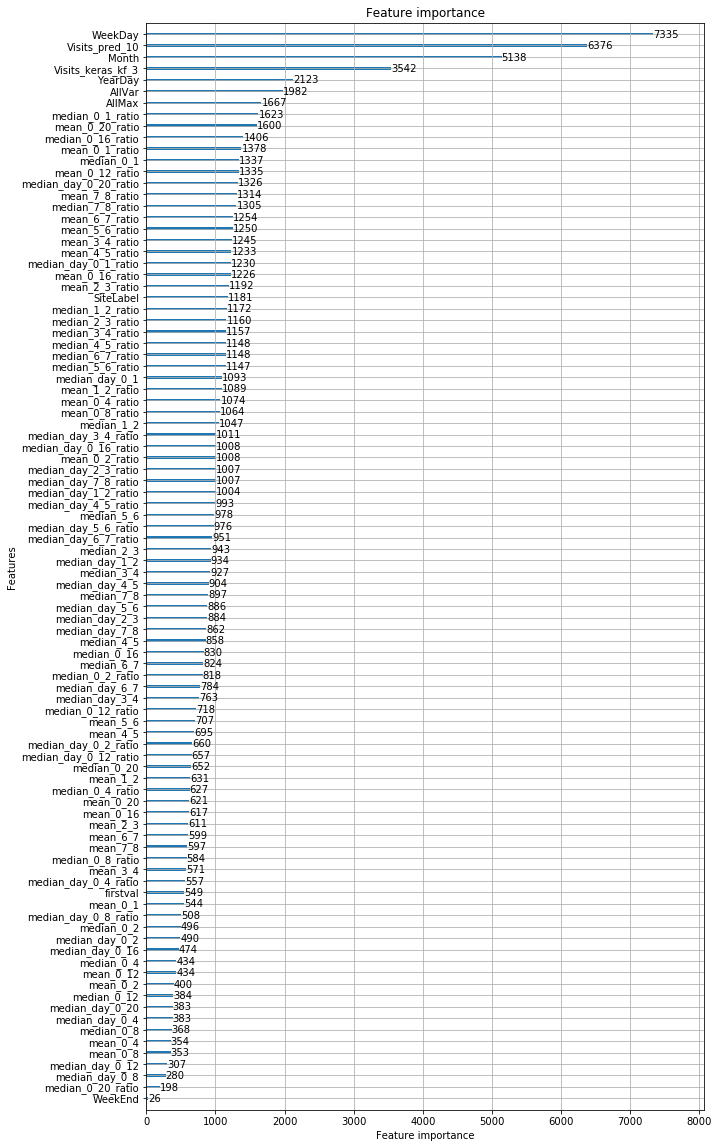

In [77]:
features2 = [c for c in features if c not in ['AllVisits']]

from numba import jit
import math

def smape_log(y_true, y_pred):
    return smape_fast(np.expm1(y_true), np.expm1(y_pred))

@jit
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        if b < 0.85:
            b = 0
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (2.0 / y_true.shape[0])
    return out


def cross_validate_xgb_median(param, x_train, y_train, y_train_base, y_true, x_test, y_test_base, kf, 
                       num_boost_round, 
                       fname, nseed=1, verbose_eval=100,
                       target='Visits', featimp=True, save_pred=False,
                       ):
    
    if save_pred:
        now = datetime.datetime.now()
        now = str(now.strftime('%Y-%m-%d-%H-%M-%S'))
        print('started at:', now)
        print('num bagging seeds:', nseed)
        fname = '../submissions/'+fname+'_'+now
        print(x_train.shape, x_test.shape)
    
    nfold = kf.n_splits
    print('nfold', nfold)
        
    
    train_pred = np.zeros((x_train.shape[0]))
    test_pred = np.zeros((x_test.shape[0]))
        
    d_test = xgb.DMatrix(x_test, silent=True)    

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        print('train fold', i)
        x_train_kf, x_test_kf = x_train.loc[train_index,:].copy(), x_train.loc[test_index,:].copy()
        y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]
        y_train_base_kf, y_test_base_kf = y_train_base[train_index], y_train_base[test_index]
        y_true_kf, y_true_kf = y_true[train_index], y_true[test_index]

        d_train_kf = xgb.DMatrix(x_train_kf, label=y_train_kf)
        d_test_kf = xgb.DMatrix(x_test_kf, label=y_test_kf)
        
        n = x_train_kf.shape[0]
        grad = np.empty(n)
        hess = 500 * np.ones(n)
        
        @jit
        def grad_fast1(preds,  dtrain, n=n, grad=grad, hess=hess):
            labels = dtrain.get_label()
            for i in range(n):
                diff = preds[i] - labels[i]
                if diff > 1:
                    grad[i] = 0
                elif diff < -1:
                    grad[i]=0
                elif diff > 0:
                    grad[i] = 200
                elif diff < 0:
                    grad[i] = -200
                else:
                    grad[i] = 0
            return grad, hess
        
        @jit
        def grad_fast(preds,  dtrain, n=n, grad=grad, hess=hess):
            labels = dtrain.get_label()
            for i in range(n):
                diff = (preds[i] - labels[i])
                if diff > 0:
                    grad[i] = 800 / (1 + diff)**2
                elif diff < 0:
                    grad[i] = -800 / (1 - diff)**2
                else:
                    grad[i] = 0
            return grad, hess

        @jit
        def smape_eval_log(y_pred, dtrain, y_base=y_test_base_kf, y_true=y_true_kf):
            out = 0
            for i in range(y_true.shape[0]):
                a = y_true[i]
                b = np.expm1(y_pred[i] + y_base[i])
                if b < 0.85:
                    b = 0
                b = np.round(b)
                c = a+b
                if c == 0:
                    continue
                out += math.fabs(a - b) / c
            out *= (2.0 / y_true.shape[0])
            return 'smape', out

        
        for seed in range(nseed):
            param['seed'] = seed
            bst = xgb.train(param, d_train_kf, num_boost_round=num_boost_round,
                            evals=[( d_test_kf, 'test')], verbose_eval=verbose_eval,
                            early_stopping_rounds=25, feval=smape_eval_log, obj=grad_fast
                           )
            pred = bst.predict(d_test_kf, ntree_limit=bst.best_ntree_limit)
            train_pred[test_index] += (pred +  y_test_base_kf)
            pred = bst.predict(d_test, ntree_limit=bst.best_ntree_limit)
            test_pred += (pred + y_test_base)
        train_pred[test_index] /= nseed    
        print('fold cv smape: %0.5f' % smape_log(y_test_kf + y_test_base_kf, train_pred[test_index]),
              bst.best_ntree_limit)
        print()
        del d_train_kf
        del d_test_kf
        gc.collect()
    
    train_pred = np.expm1(train_pred)
    train_pred[train_pred < 0.85] = 0
    train_pred = train_pred.round()
    test_pred /= (nfold * nseed)
    test_pred = np.expm1(test_pred)
    test_pred[test_pred < 0.85] = 0
    test_pred = test_pred.round()
    
    print('cv      smape:%0.5f' % smape(np.expm1(y_train + y_train_base), train_pred))
    if save_pred:
        #save for ensembling
        print('saving train prediction to:', fname+'_train.csv')

        preds = pd.DataFrame(train_pred)
        preds.columns = [target]
        preds.to_csv(fname+'_train.csv', index=None)
        print(preds[target].mean())

        print('saving test prediction to:', fname+'_test.csv')
        preds = test_all[['Id']].copy()
        preds[target] = test_pred
        preds.to_csv(fname+'_test.csv', index=None)
        print(preds[target].mean())        
        now = datetime.datetime.now()
        now = str(now.strftime('%Y-%m-%d-%H-%M-%S'))
        print('ended at:', now)

    if featimp:
        fig, ax = plt.subplots(1, 1, figsize=(10, 20))

        xgb.plot_importance(bst, ax=ax, height=0.2, xlim=None, ylim=None, 
                        title='Feature importance', xlabel='Feature importance', ylabel='Features', )
        plt.show()
        


    return bst, train_pred, test_pred


try:
    del x_train
    del y_train
    del y_train_base
    del x_test
    del x_test_base
    del bst
    del train_pred
    del test_pred
except:
    pass

gc.collect()
gc.collect()

x_train = test2[features2]
y_train = np.log1p(test2.Visits_true.values.ravel())
y_train_base = np.log1p(test2.Visits_keras_kf_3.values.ravel())
y_true = test2.Visits_true.values.ravel()
y_train -= y_train_base
x_test = test_all1[features2]
y_test_base = np.log1p(test_all1.Visits_keras_kf_3.values.ravel())

params =  {
  "objective"           : "reg:linear",
  "eval_metric"         : "rmse",
  "eta"                 : 0.01,
  "max_depth"           : 9,
  "min_child_weight"    : 400,
  "gamma"               : 0.0,
  "subsample"           : 0.77,
  "colsample_bytree"    : 0.95,
  "alpha"               : 2e-05,
  "lambda"              : 10,
    'tree_method'       : 'hist',
    'nthread'           : 10,
    'base_score' : 0,
    #'max_delta_step'    : 1,
}

kf = KFold(5)
num_boost_round = 5000
fname = 'xgb_1'
bst, train_pred, test_pred = cross_validate_xgb_median(params,  
                                                       x_train, y_train, y_train_base, y_true,
                                                       x_test, y_test_base,  
                                                       kf, 
                       num_boost_round, 
                       fname, nseed=1, verbose_eval=1,
                       target='Visits', featimp=True, save_pred=True,
                       )